In [1]:
import sys
import time
import bibtexparser
import itertools
import requests
import re
import matplotlib as plt
import pandas as pd
from bs4 import BeautifulSoup
from tabulate import tabulate
import numpy as np

In [2]:
import bibtexparser
bibtex_file = open('gap-publishednicer.bib.txt', encoding='utf-8')
bib_data = bibtexparser.load(bibtex_file)

In [3]:
bib = bib_data.entries

### Here are the 3 datasets we will start with.

In [4]:
bib_df = pd.DataFrame.from_dict(bib) # large one from the Bibliography
review_df = pd.read_csv('no_citation_text.csv', dtype='str') # MR numbers who came back with no `GAP` text found inside
corpus_df = pd.read_csv('gap_citations_corpus.csv', dtype='str') # CItations scraped from MathSciNet website

# Larger dataset from Bibliography

* how to deal with NaN missing values ? *

We only need some of these columns, hence we `drop` the rest.

In [5]:
bib_df.columns

Index(['printedkey', 'doi', 'url', 'mrreviewer', 'mrnumber', 'mrclass', 'issn',
       'fjournal', 'pages', 'year', 'volume', 'journal', 'title', 'author',
       'ENTRYTYPE', 'ID', 'number', 'school', 'booktitle', 'isbn', 'note',
       'publisher', 'day', 'keywords', 'month', 'series', 'annote', 'type',
       'address', 'institution', 'howpublished', 'editor', 'bookeditor',
       'edition', 'key', 'organization'],
      dtype='object')

In [6]:
bib_df.drop(bib_df.columns[[0, 1, 2, 3, 5, 6, 7, 8, 10, 12, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]], axis = 1, inplace = True)

In [7]:
bib_df.columns

Index(['mrnumber', 'year', 'journal', 'author', 'ENTRYTYPE'], dtype='object')

We reorder the columns.

In [8]:
bib_df = bib_df[['mrnumber', 'author', 'journal', 'year', 'ENTRYTYPE']]

Then we change the `mrnumber` coulmn name to `MR` so we cane later merge this dataframe with the other one.

In [9]:
bib_df.columns = ['MR', 'Author', 'Journal', 'Year', 'Publication Type']
bib_df

,MR,Author,Journal,Year,Publication Type
0,4056124,"Abas, M. and Vetrík, T.",Theoret. Comput. Sci.,2020,article
1,3942387,"Abbas, A. and Assi, A. and García-Sánchez, P. A.",Rev. R. Acad. Cienc. Exactas Fís. Nat. Ser. A ...,2019,article
2,NaN,"Abdeljaouad, I.",RAIRO-INF THEOR APPL,1999,article
3,3354065,"Abdolghafourian, A. and Iranmanesh, M. A.",Comm. Algebra,2015,article
4,3646312,"Abdolghafourian, A. and Iranmanesh, M. A. and ...",J. Pure Appl. Algebra,2017,article
...,...,...,...,...,...
3362,2647300,"Zusmanovich, P.",J. Geom. Phys.,2010,article
3363,2735394,"Zusmanovich, P.",J. Algebra,2010,article
3364,3201064,"Zusmanovich, P.",J. Algebra,2014,article
3365,3598575,"Zusmanovich, P.",Linear Algebra Appl.,2017,article


Data types and count of non-null values for each columns.

In [10]:
bib_df.info(show_counts  = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3367 entries, 0 to 3366
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   MR                3159 non-null   object
 1   Author            3367 non-null   object
 2   Journal           3047 non-null   object
 3   Year              3367 non-null   object
 4   Publication Type  3367 non-null   object
dtypes: object(5)
memory usage: 65.8+ KB


Looking at the `MRN` columns, some cells are empty - `NaN`

In [11]:
bib_df.iloc[3274]

MR                            NaN
Author                 Wegner, A.
Journal                       NaN
Year                         1989
Publication Type    mastersthesis
Name: 3274, dtype: object

In [12]:
bib_df.describe()

,MR,Author,Journal,Year,Publication Type
count,3159,3367,3047,3367,3367
unique,3158,2511,384,43,10
top,3656296,"Sambale, B.",J. Algebra,2017,article
freq,2,18,387,188,2976


### We will look at the `year` column. There are several anomalies and we need just 4 digits in each cell.

In [13]:
bib_df.sort_values('Year', ascending=False)

,MR,Author,Journal,Year,Publication Type
3165,3973299,"Then, H.",NaN,[2019] \copyright 2019,incollection
1546,3898507,"Greer, M.",NaN,[2019] \copyright 2019,incollection
3133,3898514,"Stuhl, I. and Vojtěchovský, P.",NaN,[2019] \copyright 2019,incollection
3147,3782458,"Swinarski, D.",NaN,[2018] \copyright 2018,incollection
1981,4167659,"Kaushik, R. and Yadav, M. K.",J. Algebra,2021,article
...,...,...,...,...,...
3274,NaN,"Wegner, A.",NaN,1989,mastersthesis
2689,NaN,"Niemeyer, A.",NaN,1988,mastersthesis
2673,NaN,"Nickel, W.",NaN,1988,mastersthesis
3018,NaN,"Schönert, M.",NaN,1987,mastersthesis


We will use `.str` and a regular expresion `(r'^(\d{4})'` which first converts all year cells to strings then takes the first 4 digits from each. We then replace the old values with the filtered ones.

In [14]:
bib_df['Year'] = bib_df['Year'].str.extract(r'^(\d{4})', expand=False)

In [15]:
bib_df['Year'].value_counts()

2017    188
2013    175
2018    168
2020    166
2019    165
2010    163
2015    162
2016    158
2014    154
2011    152
2007    142
2012    142
2008    132
2004    131
2005    128
2009    124
2006    118
2001    107
2003    101
1999     84
2002     84
2000     78
1997     76
1998     58
1995     56
2021     39
1996     34
1994     28
1993     25
1992     13
1991      5
1989      2
1988      2
1987      2
1990      1
Name: Year, dtype: int64

Now we convert the column Data type back to numeric.

bib_df['Year'] = pd.to_numeric(bib_df['Year'])

bib_df['Year'] = bib_df['Year'].astype(np.int64)

In [16]:
# we use this option to remove the trailing zeors behind the year.
# pd.options.display.float_format = '{:.0f}'.format 

We inspect the result and no more anomalies are visible. Data type is integer which is also fine.

#  Corpus and Review

What are the GAP Citation practices ???
The longer the citation is the more details it contains - measure lenght ?

To do
+ check Citations strings lenghts to isolate too short ones

+ website count citations hacing `gap.com` string to measure how many mention the website
+ remaining HTML characters

Two citations containing Singapore instead of GAP present.



In [17]:
corpus_df

,MR,Citation
0,MR4056124,"GAP – Groups, algorithms, programming - a syst..."
1,MR3942387,"Delgado, M., García-Sánchez, P.A., Morais, J.:..."
2,MR3942387,"The GAP Group: GAP—groups, algorithms, and pro..."
3,MR3354065,"The GAP – Groups, Algorithms and Programming. ..."
4,MR3646312,"The $\ssf{GAP}$ Group, $\ssf{GAP}$–Groups, Alg..."
...,...,...
3537,MR3988630,"M. Delgado, P. A. García-Sánchez and J. Morais..."
3538,MR1801202,"L.H. Soicher, GRAPE: a system for computing wi..."
3539,MR2558870,"L. Bartholdi, Functionally recursive groups, h..."
3540,MR2824780,"X. Sun, C. Liu, D. Li and J. Gao, On duality g..."


In [18]:
pd.options.display.max_colwidth = 157

In [19]:
# Python lectures by Dr Konovalov 
# https://studres.cs.st-andrews.ac.uk/CS2006/Lectures/Python/L08-dataset.pdf

def get_citation(mrno):
    r = corpus_df[corpus_df['MR'] == mrno]
    return r.at[r.index[0],'Citation'], r.at[r.index[0],'Version']

In [20]:
# Python lectures by Dr Konovalov 
# https://studres.cs.st-andrews.ac.uk/CS2006/Lectures/Python/L08-dataset.pdf

def get_c(mrno):
    r = merged_df[merged_df['MR'] == mrno]
    return r

In [183]:
# Python lectures by Dr Konovalov 
# https://studres.cs.st-andrews.ac.uk/CS2006/Lectures/Python/L08-dataset.pdf

unknown_ver = []

def get_version(s):
    match = re.search("(?:(\d+\.(?:\d+\.)*\d+))", s, re.IGNORECASE)
    if match != None:
        return match.group(1)
        print('* VERSION FOUND *')
    else:
        print('* No VERSION found *', s)
        unknown_ver.append(s)
        return 'Unknown'

In [22]:
def is_package(series):
    mrno = series['MR']
    citation = series['Citation']
    version = series['Version']
    if re.search("package", citation, re.IGNORECASE) != None:
        print('***Package***:', mrno, citation)
        return 'Package'
    else:
        print('***Not a Package***:', mrno, citation)
        return series['Version']

In [23]:
def website_check(series):
    mrno = series['MR']
    citation = series['Citation']
    version = series['Version']
    if re.search("www|\.net|http", citation, re.IGNORECASE) != None:
        print('***Provided Website***:', mrno, citation)
        return 'Yes'
    else:
        print('***Not Provided***:', mrno, citation)
        return 'No'

* First we create the version column. Then we fill its cells with the version, where provided.

In [24]:
corpus_df.insert(loc=2, column='Version', value=' ')

In [184]:
corpus_df['Version'] = corpus_df['Citation'].map(get_version)

* No VERSION found * GAP – Groups, algorithms, programming - a system for computational discrete algebra, www.gap-system.org.
* No VERSION found * Delgado, M., García-Sánchez, P.A., Morais, J.: "Numerical Sgps", A GAP package for numerical semi-groups. https://gap-packages.github.io/numericalsgps. Accessed 19 Aug 2017 
MR3493240
* No VERSION found * M. Schönert et al. GAP - Groups, Algorithms, and Programming (Lehrsthul D für Mathematik, Reinisch-Westflische Technische Hochschule, Aachen, Germany, fifth ed., 1995.)
* No VERSION found * W. Nickel, NQ, 1998, A refereed GAP 4 package, see [10].
* No VERSION found * W. Nickel, NQ, 1998, A refereed GAP 4 package, see [8].
* No VERSION found * Gamble, G., Nickel, W., O'Brien, E.A.: ANU p-Quotient–p-Quotient and p-Group Generation Algorithms (2006). An accepted GAP 4 package, available also in MAGMA
* No VERSION found * M. Schönert et al, GAP: groups, algorithm and programming, © 1992 by Lehrstuhl D für Mathematik, distributed with the GAP so

* No VERSION found * M. Schönert et al., GAP–Groups, Algorithms, and Programming, Lehrstuhl ${\rm D}$ für Mathematik, Rheinisch Westfälische Technische Hochschule, Aachen, Germany, fifth edition, 1995.
* No VERSION found * M. Schönert et al., "GAP - Groups, Algorithms, and Programming", Lehrstuhl D für Mathematik, Rheinisch Westfälische Technische Hochschule, Aachen, fifth edition, 1995.
* No VERSION found * M. Schönert et al., "GAP—Groups, Algorithms and Programming," Lehrstuhl D für Mathematik, RWTH, Aachen, 1994.
* No VERSION found * M. Schönert et al., GAP - Groups, Algorithms and Programming, Lehrstuhl D für Mathematik, Rheinisch Westfälische Technische Hochschule, Aachen, Germany, fifth edition, 1995.
* No VERSION found * M. Schönert et al., GAP-Groups, Algorithms, and Programming, 5th edition, Lehrstuhl D für Mathematik, Rheinisch-Westfälische Technische Hochschule, Aachen, Germany, 1995.
* No VERSION found * M. Schönert et al., GAP - Groups, Algorithms, and Programming, 5th Edi

* No VERSION found * G. Gamble, A. Hulpke, G. Havas, C. Ramsay, M. Horn, GAP Package ACE, http://gap-packages.github.io/ace/, 1998.
* No VERSION found * M. Schönert, et al., GAP—Groups, Algorithms and Programming, fourth ed., RWTH Aachen: Lehrstuhl D für Mathematik, 1994.
* No VERSION found * G. Pfeiffer, Character tables of Weyl groups in GAP, Bayreuther Math. Schr. 47 (1994), 165–222. 
MR1285208
* No VERSION found * J.-G. Dumas, F. Heckenbach, B. D. Saunders and V. Welker, GAP Homology, http://www.eecis.udel.edu/dumas/Homology (2011).
* No VERSION found * Peter Webb, Tutorial on the gap package `reps' for handling group representations in positive characteristic, http://www-users.math.umn.edu/~webb/GAPfiles/reptutorial.html, 2016.
* No VERSION found * GAP, Groups, algorithms, programming—a system for computational discrete algebra, http://www-gap.mcs.st-and.ac.uk/.
* No VERSION found * Aichinger, E., Binder, F., Ecker, J., Mayr, P., Nöbauer, C.: SONATA—system of near-rings and their 

In [186]:
corpus_df['Version'].value_counts()

Unknown     895
4.4         460
4.4.12      310
4.3         232
4.4.10      136
           ... 
1.7           1
1.8.4         1
1.10.6        1
3.2           1
10.01.16      1
Name: Version, Length: 197, dtype: int64

Then we apply the function which chekcs if it is a case of citing GAP Package. Packages are connected to GAP, but technically is a separate piece of software. In entries citing GAP package there is no version of GAP provided hence we will fill the `Version` cell with `Package`.

In [187]:
corpus_df['Version'] = corpus_df.apply(is_package,axis=1)

***Not a Package***: 4056124 GAP – Groups, algorithms, programming - a system for computational discrete algebra, www.gap-system.org.
***Package***: 3942387 Delgado, M., García-Sánchez, P.A., Morais, J.: "Numerical Sgps", A GAP package for numerical semi-groups. https://gap-packages.github.io/numericalsgps. Accessed 19 Aug 2017 
MR3493240
***Not a Package***: 3942387 The GAP Group: GAP—groups, algorithms, and programming, version 4.7.5 (2014). http://www.gap-system.org. Accessed 19 Aug 2017
***Not a Package***: 3354065 The GAP – Groups, Algorithms and Programming. Version 4.4.12, 2008. www.gap-system.org.
***Not a Package***: 3646312 The $\ssf{GAP}$ Group, $\ssf{GAP}$–Groups, Algorithms, and Programming, 4.7.8, 2015, http://www.gap-system.org.
***Not a Package***: 1864795 M. Schönert et al. GAP - Groups, Algorithms, and Programming (Lehrsthul D für Mathematik, Reinisch-Westflische Technische Hochschule, Aachen, Germany, fifth ed., 1995.)
***Not a Package***: 2287843 The GAP Group, GAP 

***Not a Package***: 3801282 The GAP Group, GAP — Groups, Algorithms, and Programming, Version 4.8.4 (2016); http://www.gap-system.org.
***Not a Package***: 3686981 The GAP Group, GAP — groups, algorithms, and programming, version 4.7.9, http://www.gapsystem.org, 2015.
***Not a Package***: 2889543 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.4 (2006) Available at http://www.gap-system.org
***Not a Package***: 3169027 The GAP Group. GAP - Groups, Algorithms and Programming, Version 4.4, 2006 (http://www.gap-system.org)
***Not a Package***: 3461068 The GAP Group, GAP - Groups, Algorithms, and Programming, version 4.6.2, http://www.gap-system.org, 2013.
***Not a Package***: 2652482 The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.4.12, http://www.gap-system.org, 2008.
***Package***: 2652482 R.A. Wilson, R.A. Parker, S.J. Nickerson, J.N. Bray, T. Breuer, AtlasRep, A GAP Interface to the Atlas of Group Representations, Version 1.4 2008, Refereed GAP p

***Not a Package***: 1626409 M. Schönert et al., GAP version 3.4, 4th edition, Lehrstuhl D für Mathematik, RWTH Aachen, 1995.
***Not a Package***: 2040575 The GAP Group, Aachen, St Andrews. GAP–Groups, algorithms and programming, Version 4.2, 2000, (http://www-gap.dcs.st-and.ac.uk/$\sim$gap).
***Package***: 3917961 Delgado, M., García-Sánchez, P.A., Morais, J.: "NumericalSgps"—a GAP package, Version 1.1.5. http://www.gap-system.org/Packages/numericalsgps.html. Accessed 25 Sept 2017
***Not a Package***: 3917961 The GAP Group. GAP—Groups, Algorithms, and Programming, Version 4.8.4 (2016). http://www.gap-system.org. Accessed 4 June 2016
***Not a Package***: 3483355 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.4.10, 2007. http://www.gap-system.org
***Not a Package***: 3622353 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.4.10, 2007. http://www.gap-system.org
***Not a Package***: 3145212 The GAP Group, GAP – Groups, Algorithms, and Programming, V

***Not a Package***: 4135540 The GAP Group, GAP – groups, algorithms, and programming, version 4.8, http://www.gap-system.org, 2016.
***Not a Package***: 3819540 GAP, Groups, Algorithms, Programming – A system for computational discrete algebra, version 4.8.3 (2016), www.gap-system.org.
***Not a Package***: 4109463 The GAP Group: GAP – Groups, Algorithms, and Programming, Version 4.10.2 (2019). https://www.gap-system.org
***Not a Package***: 3655698 The GAP Group, GAP—groups, algorithms, and programming, version 4.7.5, 2014, http://www.gap-system.org.
***Not a Package***: 3143585 The GAP Group, GAP—Groups, Algorithms, and Programming, version 4.4.12 (2008), http://www.gap-system.org.
***Not a Package***: 2148485 M. Schönert, et al., GAP—Groups, Algorithms, and Programming, fifth ed., Lehrstuhl D für Mathematik, Rheinisch Westfälische Technische Hochschule, Aachen, Germany, 1995.
***Not a Package***: 2526793 The GAP Group: GAP–Groups, Algorithms, and Programming, Version 4.4.9; 2006 (ht

***Not a Package***: 2242478 GAP—Groups, Algorithms and Programming, Version 4.3, 2002.
***Not a Package***: 3879476 The GAP Group.: GAP - Groups, Algorithms, and Programming, Version 4.8.6 (2016). https://www.gap-system.org/
***Package***: 3346170 GAP SmallGroups Library www.gap-system.org/Packages/sgl.html (accessed 18 December 2014)
***Not a Package***: 3432870 The GAP Group, GAP — Groups, Algorithms, and Programming, Version 4.4.12 (2009); http://www.gap-system.org.
***Not a Package***: 2824088 GAP: Groups, algorithms and programming, http://www.gap-system.org/
***Not a Package***: 3534498 The GAP Group, GAP—Groups, Algorithms, and Programming. Version 4.6.2 (2013). http://www.gap-system.org
***Not a Package***: 2652224 GAP. "GAP—Groups, Algorithms and Programming, Version 4.4.10, 2007." The GAP Group. http://www.gap-system, org.
***Not a Package***: 3395061 The GAP Group, GAP – groups, algorithms and programming, Version 4.4.10, http://www.gap-system.org, 2007.
***Not a Package***

***Not a Package***: 4040183 The GAP Group, GAP –Groups, Algorithms, and Programming, http://www.gapsystem.org.
***Not a Package***: 4134829 A. S. Detinko, D. L. Flannery, and A. Hulpke, GAP Functionality for Zariski Dense Groups, Oberwolfach Preprints OWP 2017-22.
***Not a Package***: 4134829 The GAP Group, GAP – Groups, Algorithms, and Programming, http://www.gapsystem.org
***Package***: 4134829 M. Neunhöffer, Á. Seress, et al., "The GAP Package recog." A Collection of Group Recognition Methods, http://gap-packages.github.io/recog/
***Not a Package***: 3294861 The GAP Group, GAP—Groups, algorithms, and programming, Version 4.4.12; 2008. (http://www.gap-system.org)
***Not a Package***: 2721798 The GAP Group, GAP-Groups, Algorithms and Programming Version 4.3 Aachen, St Andrews. (2002). (http://www.gap-system.org).
***Not a Package***: 2128082 The GAP Group (2002) GAP: Groups, Algorithms, and Programming, Version 4.3. http://www.gap-system.org
***Not a Package***: 2434275 The GAP Group

***Not a Package***: 2093885 Ellis, G., 2004. GAP code for computing group resolutions. http://www.maths.nuigalway.ie.
***Not a Package***: 2093885 The GAP Group, 1998. GAP–Groups, Algorithms and Programming. School of Mathematical and Computational Sciences, University of St. Andrews, Scotland.
***Not a Package***: 2601009 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.4.9, 2006, http://www.gap-system.org.
***Package***: 2595184 G. Ellis, Homological algebra programming. A GAP package for computational homological algebra. http://www.gap-system.org/Packages/hap.html
***Not a Package***: 2765374 Romero, A., Ellis, G., Rubio, J., Interoperating between computer algebra systems: computing homology of groups with Kenzo and GAP, in: ISAAC Proceedings 2009, pp. 8. 
MR2742718
***Not a Package***: 2818950 H. Dietrich, B. Eick and D. Feichtenschlager. Investigating $p$-groups by coclass with GAP. In Computational group theory and the theory of groups, Contemp. Math. 470 (Ame

***Not a Package***: 3597026 S. P. Glasby, Supporting $\ssf{GAP}$ and Magma code, http://www.maths.uwa.edu.au/~glasby/RESEARCH.
***Not a Package***: 1678153 M. SCHO NERT et al., `GAP: groups, algorithms, and programming', RWTH Aachen, 1992.
***Not a Package***: 1623957 M. Schönert et al., "GAP: Groups, Algorithms, and Programming," RWTH, Aachen, 1992.
***Not a Package***: 2078936 GAP—Groups, Algorithms, and Programming, Version 4.3, 2002, http://www.gap-systems.org.
***Not a Package***: 3686942 GAP—Groups, Algorithms, and Programming, vers. 4.6.5 (2013); http://www.gap-system.org.
***Not a Package***: 3498138 The GAP Group, GAP – Groups, Algorithms, and Programming, version 4.7.7 (2015), http://www.gap-system.org.
***Not a Package***: 2489272 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.4.9, 2006. http://www.gap-system.org.
***Not a Package***: 2581098 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4.9. (2006) http://www.gap-system.org
***Not a P

***Not a Package***: 2039809 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.3, 2002. Available from: $<$http://www.gap-system.org$>$.
***Package***: 3096858 G. P. Nagy and P. Vojtěchovský, LOOPS: Computing with quasigroups and loops, version 2.0.0, package for GAP, http://www.math.du.edu/loops.
***Not a Package***: 2375471 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4, http://www.gap-system.org (2005), Accessed 31 October 2007.
***Not a Package***: 2375471 Gamble G., Havas G., Hulpke A., Ramsay C.: ACE: a GAP 4 interface to the Advanced Coset Enumerator of G. Havas and C. Ramsay. http://www.math.rwth-aachen.de/$\sim$Greg.Gamble/ACE/, (2000), Accessed 31 October 2007.
***Not a Package***: 3510826 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.6.3; 2013, (http://www.gap-system.org).
***Package***: 3510826 W. Gamble, A. Hukpke, G. Havas and C. Ramsay, ACE – Advanced coset enumerator, A refereed GAP 4 package, see [7].
***Packag

***Not a Package***: 1930299 The GAP Team, "GAP—Groups, Algorithms, and Programming," Lehrstuhl D für Mathematik, RWTH Aachen and School of Mathematical and Computational Sciences, Univ. St. Andrews, Scotland, 1997.
***Not a Package***: 2369146 The GAP Group, GAP-Groups, Algorithms, and Programming, Version 4.4; 2005 (http://www.gap-system.org)
***Not a Package***: 1863400 M. Schönert et al., GAP 3.4.3 manual (Groups, Algorithms and Programming) Lehrstuhl D für Mathematik, RWTH Aachen, 1996.
***Not a Package***: 3553394 The GAP group, GAP – Groups, Algorithms, Programming, Version 4.4, http://www.gap-system.org/, 2004.
***Not a Package***: 4066477 The GAP Group, GAP -Groups, Algorithms, and Programming, Version 4.4; 2004, http://www.gap-system.org.
***Not a Package***: 4097880 The GAP Group, GAP groups, algorithms, and programming, version 4.4, http://www.gap-system.org, 2004.
***Package***: 3418065 L. Bartholdi, FR – GAP package "Computations with functionally recursive groups", Versi

***Not a Package***: 2599868 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4.10, 2007, $<$http://www.gap-system.org$>$.
***Not a Package***: 3963068 The GAP Group (2016). GAP-Groups, Algorithms and Programming, Version 4.8.4. http://www.gap-system.org
***Not a Package***: 4150752 GAP Group. (2016). GAP-Groups, Algorithms and Programming, Version 4.8.4. http://www.gap-system.org.
***Not a Package***: 4190609 G.A.P. The, GAP - groups, algorithms and programming, version 4.8.7, http://www.gap-system.org, 2017.
***Not a Package***: 2043989 The GAP Group. GAP—Groups, Algorithms, and Programming, Version 4.2. Available from World Wide Web (http://www.gap-system.org), 2000.
***Package***: 2063042 K. Magaard, S. Sphectorov and H. Völklein, A GAP package for braid orbit computation, and applications, Experimental Mathematics, to appear. 
cf. MR2043989
***Not a Package***: 2470540 The GAP Group. GAP—Groups, Algorithms, and Programming. Version 4.4.9; 2007, (http://www.gap-sys

***Not a Package***: 2104296 The GAP Group, GAP - Groups, Algorithms and Programming. Version 4.3; 2002 (http://www.gap-system.org.)
***Not a Package***: 2515272 The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.3, 2002 (http://www.gap-system.org).
***Not a Package***: 3114008 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.4.12 (2008). URL http://www.gap-system.org.
***Package***: 3537826 T. Breuer, GAP-package CTblLib—the GAP character table library, Version 1.2.2, http://www.gap-system.org/Packages/ctbllib.html, 2013.
***Not a Package***: 3537826 J. Michel, CHEVIE—development version of the GAP part of CHEVIE, http://webusers.imj-prg.fr/~jean.michel/chevie.html.
***Not a Package***: 2836997 The GAP Group, GAP-4.4 — Groups, Algorithms, and Programming, 2006 (http://www.gap-system.org).
***Not a Package***: 3928645 The GAP Group, GAP–groups, algorithms, programming–asystemfor computational discrete algebra, version 4.8.6 (2016), Available at: http:/

***Not a Package***: 3029481 The GAP Group (2008) GAP—Groups, Algorithms, and Programming. http://www.gap-system.org
***Not a Package***: 1807654 M. Schönert, et al., "GAP—Groups, Algorithms, and Programming," 4th ed., 1994.
***Not a Package***: 2049014 The GAP-Group. GAP—Groups, algorithms, and programming, version 4.3 (2002). http://www-gap.dcs.st-and.ac.uk/gap/gap.html
***Not a Package***: 4150255 The GAP Group, "GAP: groups, algorithms, and programming", 2004, Available at http://www.gap-system.org. Version 4.4.
***Not a Package***: 3854485 The GAP group: GAP-Groups, Algorithms, and Programming, Version 4.7.5. http://www.gap-system.org (2014). Accessed 04 May 2014
***Not a Package***: 3776814 The GAP group, GAP-Groups, Algorithms, and Programming, Version 4.7.4, http://www.gapsystem.org, 2014.
***Not a Package***: 3969474 The GAP group (2014). GAP-Groups, Algorithms, and Programming, Version 4.7.4, http://www.gap-system.org
***Not a Package***: 4150726 The GAP Group. (2014). Algori

***Not a Package***: 4077413 The {\ssf GAP} Group, {\ssf GAP} — Groups, Algorithms, and Programming, Version 4.10.2 (2019), https://www.gap-system.org.
***Not a Package***: 3578801 The GAP Group, GAP Groups, Algorithms, and Programming, Version 4.6.4, 2013, http://www.gap-system.org.
***Not a Package***: 3634298 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.8.4; 2016. (http://www.gap-system.org)
***Package***: 3197173 G. Ellis, Hap - Homological Algebra Programming, Version 1.8, an official package for the GAP computational algebra system, http://www.gap-system.org/Packages/hap.html, 2008. 
MR2478414
***Not a Package***: 3197173 The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.4.9, http://www.gap-system.org, 2006.
***Not a Package***: 4032800 The GAP group, GAP –Groups, Algorithms, and Programming, version 4.8.10, 2018. https://www.gap-system.org
***Not a Package***: 2423808 The GAP Group, GAP: Groups, Algorithms, and Programming, Version 4.4, h

In [188]:
corpus_df['Version'].value_counts()

Package      730
Unknown      539
4.4          454
4.4.12       310
4.3          212
            ... 
1.0            1
1.3.3          1
2.19           1
1405.5063      1
10.01.16       1
Name: Version, Length: 101, dtype: int64

Now we will create a `website` coulmn to indicate if such is provided. Then we fill each cell using  a Regex to search citations for the GAP website.

In [29]:
corpus_df.insert(loc=3, column='Website', value=' ')

In [189]:
corpus_df['Website'] = corpus_df.apply(website_check, axis=1)

***Provided Website***: 4056124 GAP – Groups, algorithms, programming - a system for computational discrete algebra, www.gap-system.org.
***Provided Website***: 3942387 Delgado, M., García-Sánchez, P.A., Morais, J.: "Numerical Sgps", A GAP package for numerical semi-groups. https://gap-packages.github.io/numericalsgps. Accessed 19 Aug 2017 
MR3493240
***Provided Website***: 3942387 The GAP Group: GAP—groups, algorithms, and programming, version 4.7.5 (2014). http://www.gap-system.org. Accessed 19 Aug 2017
***Provided Website***: 3354065 The GAP – Groups, Algorithms and Programming. Version 4.4.12, 2008. www.gap-system.org.
***Provided Website***: 3646312 The $\ssf{GAP}$ Group, $\ssf{GAP}$–Groups, Algorithms, and Programming, 4.7.8, 2015, http://www.gap-system.org.
***Not Provided***: 1864795 M. Schönert et al. GAP - Groups, Algorithms, and Programming (Lehrsthul D für Mathematik, Reinisch-Westflische Technische Hochschule, Aachen, Germany, fifth ed., 1995.)
***Provided Website***: 2287

***Provided Website***: 3725240 J. D. Mitchell et al., Semigroups - GAP package, Version 2.6; 2015. Available from: http://www-groups.mcs.st-andrews.ac.uk/~jamesm/semigroups.php
***Provided Website***: 3724696 A. Distler and J. D. Mitchell. GAP package - smallsemi, v. 0.6.8 (2014). (Available at http://www-groups.mcs.st-andrews.ac.uk/~jamesm/smallsemi.)
***Provided Website***: 3666217 The GAP Group, GAP – Groups, Algorithms, and Programming, version 4.8.2, x2016, www.gap-system.org.
***Provided Website***: 3763896 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.8.7, 2017, http://www.gap-system.org/
***Not Provided***: 2995039 The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.4.12, 2008.
***Provided Website***: 2995039 James D. Mitchell, The GAP-package Citrus. Version 0.6, http://www-groups.mcs.st-andrews.ac.uk/$\sim$jamesm/citrus/index.html, 2012.
***Provided Website***: 2995039 Jürgen Müller, Max Neunhöffer, Felix Noeske, The GAP-package orb. Ver

***Provided Website***: 2329563 The GAP Group, GAP—Groups, algorithms, and programming, version 4.4, http://www.gap-system.org, 2005.
***Provided Website***: 2358065 The GAP Group: GAP—Groups, Algorithms, and Programming, Version 4.3 (2002). http://www.gap-system.org
***Provided Website***: 2782567 The GAP Group; GAP–Groups, Algorithms and Programing, Version 4.4.12, 2008, at http://www.gap-system.org/ (Accessed 2008).
***Provided Website***: 3468089 The GAP Group ( GAP—Groups, Algorithms, and Programming), Version 4.7.8. http://www.gap-system.org
***Provided Website***: 3747580 The GAP Group, GAP–Groups, Algorithms, and Programming, Vers. 4.8.7 (2017); http://www.gap-system.org.
***Provided Website***: 3975976 GAP – Groups, Algorithms, and Programming (2016). Version 4.8.5, The GAP Group http://www.gap-system.org
***Provided Website***: 2097475 The GAP Group, (1999). Aachen, St. Andrews. GAP-Groups, Algorithms, and Programming, Version 4.1 (http://www-gap.dcs.st-and.ac.uk/$\sim$gap).


***Provided Website***: 2555951 GAP. Groups, algorithms, programming - a system for computational discrete algebra, at http://www.gap-system.org/.
***Provided Website***: 2831973 The Gap Group. GAP—Groups, Algorithms, and Programming, Version 4.4.12 (2008). http://www.gap-system.org.
***Provided Website***: 3578995 The GAP Group.: GAP—groups, algorithms, and programming, Version 4.5.6 (2013). http://www.gap-system.org
***Provided Website***: 3578995 Rahm, A.D., Sánchez-García, R.J.: GAP implementation of the Davis complex (2015). http://www.gap-system.org/Packages/hap.html
***Provided Website***: 2537674 The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.4, http://www.gap-system.org, 2006.
***Provided Website***: 2970863 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4; 2006. (http://www.gap-system.org)
***Provided Website***: 3733962 The GAP Group, "GAP: groups, algorithms, and programming", software, 2015, http://www.gap-system.org. Version 4.7.8.


***Provided Website***: 3503033 M. Delgado and J. Morais. SgpViz: A GAP package to visualize finite semigroups, http://www.gap-system.org/Packages/sgpviz.html, 2008.
***Provided Website***: 3503033 The GAP Group. GAP – Groups, Algorithms, and Programming, Version 4.4, 2006. http://www.gap-system.org.
***Not Provided***: 1909574 The GAP Group, GAP: Groups, Algorithms and Programming, Version 4.2, 2000.
***Not Provided***: 2805443 Breuer, T.: Manual for the GAP Character Table Library, Version 1.1, Lehrstuhl D für Mathematik, Rheinisch Westfälische Technische Hochschule, Aachen, Germany (2004)
***Provided Website***: 2805443 The GAP group, GAP-Groups, Algorithms, Programming, http://www.gap-system.org
***Provided Website***: 3567868 G. Cooperman, ParGAP, Version 1.4.0, (2013), http://www.gap-system.org/Packages/pargap.html.
***Provided Website***: 3567868 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.7.7, 2015, http://www.gap-system.org.
***Provided Website***: 2884

***Provided Website***: 2902724 The GAP Group.: GAP—Groups, Algorithms, and Programming, Version 4.3. http://www.gap-system.org (2002)
***Provided Website***: 2234814 The GAP Group, GAP—Groups, algorithms, and programming, Version 4.3; St. Andrews, Aachen, 1999. (Visit http://www-gap.dcs.st-and.ac.uk/$\sim$gap). The GAP libraries specific to this paper are available at: http://www.math.du.edu/$\sim$petr in section research| computing.
***Provided Website***: 2431758 The GAP Group, GAP - Groups, Algorithms, and Programming, version 4.4.9, 2006. http://www.gap-system.org.
***Provided Website***: 2431758 G.P. Nagy, P. Vojtěchovský, LOOPS: Computing with quasigroups and loops, version 1.5.0, package for GAP. Distribution website: http://www.math.du.edu/loops.
***Provided Website***: 2818949 The GAP Group. GAP Groups, Algorithms, and Programming, Version 4.4.12 (2008). www.gap-system.org.
***Provided Website***: 2818949 G. P. Nagy and P. Vojtěchovský. LOOPS: Computing with quasigroups and l

***Not Provided***: 1758050 M. Schönert et al., GAP - Groups, Algorithm, and Programming, 5th edn., RWTHLDFM, Aachen, 1995.
***Provided Website***: 3436389 M. Dutour Sikirić, Polyhedral, GAP-package, version dated 2013-09-08, http://mathieudutour.altervista.org/Polyhedral/, 2013 (visited on 2014-09-08).
***Provided Website***: 3436389 The GAP Group, GAP – Groups, Algorithms, and Programming, version 4.7.5, http://www.gap-system.org, 2014-05-24.
***Provided Website***: 2059528 The GAP Group. GAP–Groups, Algorithms, and Programming, Version 4.3, 2002. (http://www.gap-system.org).
***Provided Website***: 3030511 The GAP Group, GAP - groups, algorithms and programming, version 4.4.12, http://www.gap-system.org, 2008.
***Provided Website***: 3030511 D. Traytel, GAP 4 package Hecke, version 1.3, http://home.in.tum.de/$\sim$traytel/hecke/, 2010.
***Provided Website***: 1935417 The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.2, Aachen, St Andrews, 2000, (http://www-gap.dcs.

***Provided Website***: 3104941 The GAP group, `GAP—Groups, algorithms, and programming, version 4.5.6', 2012, http://www.gap-system.org.
***Provided Website***: 3338198 The GAP Group, GAP—Groups, algorithms, and programming, version 4.5, http://www.gap-system.org, 2012.
***Provided Website***: 3344062 The GAP Group. GAP–Groups, algorithms, and programming, version 4.5. Http://www.gap-system.org, 2012
***Provided Website***: 3422375 The GAP Group (2012). GAP— Groups, algorithms, and programming, Version 4.5. http://www.gap-system.org.
***Not Provided***: 2093563 Nickel, W., 1988. Endliche Körper in dem gruppentheoretischen Programmsystem GAP. Diploma Thesis, RWTH Aachen.
***Not Provided***: 2093563 The GAP Group, 1997. GAP–groups, algorithms, and programming, Version 4. Lehrstuhl D für Mathematik, RWTH Aachen, Germany and School of Mathematical and Computational Sciences, U. St. Andrews, Scotland.
***Provided Website***: 2891215 A. M. Cohen, J.W. Knopper, GBNP, A GAP Package for Gröbne

***Provided Website***: 1961010 GAP4, The GAP-Group, GAP-Groups, Algorithms and Programming, Version 4.2; 2000, {http://www.gap-system.org}.
***Provided Website***: 3095482 The GAP Group: GAP—Groups, Algorithms, and Programming, version 4.6.4 (2013). http://www.gap-system.org
***Provided Website***: 2279241 The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.2, Aachen, St. Andrews, (http://www.gap-system.org), 1999.
***Provided Website***: 3708045 A. Bächle and L. Margolis, HeLP – Hertweck–Luthar–Passi method, Version 3.0; GAP package (2016), http://homepages.vub.ac.be/abachle/help/. 
MR3820369
***Provided Website***: 3708045 T. Breuer, The GAP Character Table Library, Version 1.2.2; GAP package (2013), http://www.math.rwth-aachen.de/~Thomas.Breuer/ctbllib.
***Provided Website***: 2782542 GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.4.12 (2008) Available at http://www.gap-system.org
***Provided Website***: 2302693 The GAP Group, GAP - Groups, Algorith

***Provided Website***: 3724429 J. M. Walsh and C. Li, Network Enumeration and Hierarchy in GAP. Accessed: Aug. 1, 2015. [Online]. Available: http://www.ece.drexel.edu/walsh/aspitrg/software.html
***Provided Website***: 3734405 The GAP Group, GAP-Group, and Semigroup, Version 4.7.7 of 13-Feb-2015, www.gap-system.org.
***Provided Website***: 3641687 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.7.9, 2015, www.gap-system.org.
***Provided Website***: 3805321 The GAP Group, GAP — Groups, Algorithms, and Programming, version 4.8.6, 2016 (http://www.gapsystem.org).
***Provided Website***: 3923582 The GAP Group. GAP—Groups, Algorithms, and Programming, Version 4.8.3 (2016), http://www.gap-system.org.
***Provided Website***: 3579668 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.7.4, http://www.gap-system.org, 2014.
***Provided Website***: 3810527 The GAP Group.: GAP-Groups, Algorithms, and Programming, Version 4.7.4. http://www.gap-system.org (2014).
*

***Provided Website***: 2415055 GAP, Groups, Algorithms, Programming, a System for Computational Discrete Algebra, Release 4.3, 06 May 2002, http://www.gap- system.org.
***Provided Website***: 2684094 The GAP Group, Gap—Groups, algorithms, and programming, version 4.4, http://www.gap-system.org, 2005.
***Provided Website***: 2802723 The GAP Group. "GAP: Groups, Algorithms, and Programming: A System for Computational Discrete Algebra." Available at http://www.gapsystem.org. Version 4.4.11, 2008.
***Provided Website***: 2303840 The GAP Group. GAP - Groups, Algorithms, and Programming, Version 4.4, 2005. (http://www.gap-system.org).
***Not Provided***: 2478410 B. Eick and W. Nickel. Polycyclic - Computing with polycyclic groups, 2002. A GAP Package, see [8]. 
MR1829476
***Not Provided***: 2478410 Greg Gamble, Werner Nickel, and Eamonn O'Brien. ANUPQ - p-quotient, 2006. A GAP Package, see [8].
***Provided Website***: 2478410 The GAP Group. GAP - Groups, Algorithms, and Programming, Version

***Provided Website***: 2791292 The GAP Group, Gap–groups, algorithms, and programming, version 4.4.10, 2007, http://www.gap-system.org.
***Provided Website***: 3138075 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.3, 2002. (http://gap-system.org).
***Provided Website***: 3119318 J.-G. Dumas, F. Heckenbach, B. D. Saunders and V. Welker, GAP Homology, http://www.eecis.udel.edu/dumas/Homology (2011).
***Provided Website***: 2825713 The GAP Group: GAP—Groups, Algorithms, and Programming, Version 4.4.10 (2007). http://www.gap-system.org
***Provided Website***: 3004463 The GAP Group, GAP - Groups, algorhithms, and programming, Version 4.4.12, 2008 http://www.gap-system.org.
***Not Provided***: 4016505 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.8.9, 2017.
***Provided Website***: 4016505 Peter Webb, Tutorial on the gap package `reps' for handling group representations in positive characteristic, http://www-users.math.umn.edu/~webb/GAPfiles/reptutor

***Provided Website***: 3017840 Nagy G., Vojtěchovský P., LOOPS: Computing with quasigroups and loops in GAP, Version 2.0.0, (2008), (http://www.math.du.edu/loops). 
MR2379126
***Provided Website***: 3298668 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.4.12; 2008, http://www.gap-system.org
***Provided Website***: 3404474 GAP. GAP–Groups, Algorithms, and Programming, Version 4.7.4. The GAP Group, 2014. URL http://www.gap-system.org.
***Provided Website***: 3100139 GAP group, Algorithms and Programming, Version 4.4.9, 2006, http://www.gap-system.org.
***Provided Website***: 2228647 The GAP Group, GAP—Groups, Algorithms, and Programming, version 4.4, http://www.gap-system.org/, 2005.
***Provided Website***: 2228647 L.H. Soicher, The GRAPE 4.2 Package for GAP 4.4, http://www.maths.qmul.ac.uk/$\sim$leonard/grape/, 2003.
***Provided Website***: 2652095 The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.4, 2006, http://www.gap-system.org/.
***Provided Web

***Provided Website***: 2969025 The GAP Group, GAP-Groups, Algorithms, and Programming, Version 4.4; 2005, (http://www.gap-system.org).
***Provided Website***: 2989679 The GAP Group, GAP-Groups, Algorithms, and Programming, Version 4.4; 2005, (http://www.gap-system.org).
***Provided Website***: 2995893 The GAP Group, GAP-Groups, Algorithms, and Programming, Version 4.4; 2005, (http://www.gap-system.org).
***Provided Website***: 3063450 The GAP Group, GAP-Groups, Algorithms, and Programming, Version 4.4; 2005, http://www.gap-system.org.
***Provided Website***: 3200123 The GAP Group, GAP-Groups, Algorithms, and Programming, Version 4.4 (2005), http://www.gap-system,org.
***Provided Website***: 3439883 The $\ssf{GAP}$ Group, $\ssf{GAP}$-Groups, Algorithms and Programming, Version 4.4, 2005 (http://www.gap-system.org).
***Provided Website***: 2287647 The GAP Group, GAP–Groups, Algorithms, and Programming, Vers. 4.4.7 (2006); http://www.gap-system.org.
***Provided Website***: 2654518 "The G

# Merging the two dataframes with the equivalent of SQL `join`

df = pd.DataFrame(lis_dic)
df = df[df.ID.isin(targets)]
df_filtered = df[df.mrnumber.isin(mrs)]

The `MR` column in `corpus_df` dataframe has the letters "MR" preceeding each number, first we will remove these letters, the the MR number format is the same in both datasets.

In [190]:
corpus_df['MR'] = corpus_df['MR'].str.extract('(\d+)', expand=False)
corpus_df

,MR,Citation,Version,Website
0,4056124,"GAP – Groups, algorithms, programming - a system for computational discrete algebra, www.gap-system.org.",Unknown,Yes
1,3942387,"Delgado, M., García-Sánchez, P.A., Morais, J.: ""Numerical Sgps"", A GAP package for numerical semi-groups. https://gap-packages.github.io/numericalsgps. A...",Package,Yes
2,3942387,"The GAP Group: GAP—groups, algorithms, and programming, version 4.7.5 (2014). http://www.gap-system.org. Accessed 19 Aug 2017",4.7.5,Yes
3,3354065,"The GAP – Groups, Algorithms and Programming. Version 4.4.12, 2008. www.gap-system.org.",4.4.12,Yes
4,3646312,"The $\ssf{GAP}$ Group, $\ssf{GAP}$–Groups, Algorithms, and Programming, 4.7.8, 2015, http://www.gap-system.org.",4.7.8,Yes
...,...,...,...,...
3537,3988630,"M. Delgado, P. A. García-Sánchez and J. Morais. Numericalsgps: a ${\ssf gap}$ package on numerical semigroups, (http://www.gap-system.org/Packages/numeri...",Package,Yes
3538,1801202,"L.H. Soicher, GRAPE: a system for computing with graphs and groups, in: L. Finkelstein and W.M. Kantor, eds., Groups and Computation, DIMACS Series in Di...",Unknown,Yes
3539,2558870,"L. Bartholdi, Functionally recursive groups, http://www.gap-systems.org/Manuals/pkg/fr/doc/manual.pdf.",Unknown,Yes
3540,2824780,"X. Sun, C. Liu, D. Li and J. Gao, On duality gap in binary quadratic programming, Available from: http://www.optimization-online.org/DB_FILE/2010/01/2512...",Unknown,Yes


In [32]:
corpus_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3542 entries, 0 to 3541
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   MR        3542 non-null   object
 1   Citation  3542 non-null   object
 2   Version   3003 non-null   object
 3   Website   3542 non-null   object
dtypes: object(4)
memory usage: 55.4+ KB


In [33]:
bib_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3367 entries, 0 to 3366
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   MR                3159 non-null   object
 1   Author            3367 non-null   object
 2   Journal           3047 non-null   object
 3   Year              3363 non-null   object
 4   Publication Type  3367 non-null   object
dtypes: object(5)
memory usage: 65.8+ KB


* With the following code we are joining the two datasets on the `MR` column and using `corpus_df` as a base. The resulting dataset will have as many lines as `corpus_df` but all columns from `bib_df` will be added, hence we will have much more information to work with.

In [191]:
merged_df = pd.merge(bib_df, corpus_df, on='MR', how='right', indicator=True)

merged_df = merged_df.dropna()
merged_df.info()

* We need to convert the `Year` column cells to integers, in order for the visualisations to work fine. We will use the `.astype` method, but before taht we have to remove all `NaN` entries, from that column.

In [194]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3531 entries, 0 to 3542
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   MR                3531 non-null   object  
 1   Author            3531 non-null   object  
 2   Journal           3440 non-null   object  
 3   Year              3531 non-null   object  
 4   Publication Type  3531 non-null   object  
 5   Citation          3531 non-null   object  
 6   Version           3531 non-null   object  
 7   Website           3531 non-null   object  
 8   _merge            3531 non-null   category
dtypes: category(1), object(8)
memory usage: 141.5+ KB


In [193]:
merged_df = merged_df.dropna(subset=['Year'])

In [195]:
type(merged_df['Year'][3])

str

In [37]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3531 entries, 0 to 3542
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   MR                3531 non-null   object  
 1   Author            3531 non-null   object  
 2   Journal           3440 non-null   object  
 3   Year              3531 non-null   object  
 4   Publication Type  3531 non-null   object  
 5   Citation          3531 non-null   object  
 6   Version           2995 non-null   object  
 7   Website           3531 non-null   object  
 8   _merge            3531 non-null   category
dtypes: category(1), object(8)
memory usage: 238.5+ KB


In [196]:
merged_df['Year'] = merged_df['Year'].astype(np.int64)

In [197]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3531 entries, 0 to 3542
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   MR                3531 non-null   object  
 1   Author            3531 non-null   object  
 2   Journal           3440 non-null   object  
 3   Year              3531 non-null   int64   
 4   Publication Type  3531 non-null   object  
 5   Citation          3531 non-null   object  
 6   Version           3531 non-null   object  
 7   Website           3531 non-null   object  
 8   _merge            3531 non-null   category
dtypes: category(1), int64(1), object(7)
memory usage: 252.3+ KB


In [198]:
type(merged_df['Year'][3])

numpy.int64

* We can use the following iteration loop to browse the resulting merged dataframe. By borwsing the raw data we can make sure everything is alright and spot any remaining issues or anomalies. In our case there are some remaining special characters, which we will remove as best as we can.

In [41]:
for index, row in merged_df.iterrows():
    print(row['MR'], row['Citation'])

4056124 GAP – Groups, algorithms, programming - a system for computational discrete algebra, www.gap-system.org.
3942387 Delgado, M., García-Sánchez, P.A., Morais, J.: "Numerical Sgps", A GAP package for numerical semi-groups. https://gap-packages.github.io/numericalsgps. Accessed 19 Aug 2017 
MR3493240
3942387 The GAP Group: GAP—groups, algorithms, and programming, version 4.7.5 (2014). http://www.gap-system.org. Accessed 19 Aug 2017
3354065 The GAP – Groups, Algorithms and Programming. Version 4.4.12, 2008. www.gap-system.org.
3646312 The $\ssf{GAP}$ Group, $\ssf{GAP}$–Groups, Algorithms, and Programming, 4.7.8, 2015, http://www.gap-system.org.
1864795 M. Schönert et al. GAP - Groups, Algorithms, and Programming (Lehrsthul D für Mathematik, Reinisch-Westflische Technische Hochschule, Aachen, Germany, fifth ed., 1995.)
2287843 The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.3; 2002, (http://www.gap-system.org).
2175389 The GAP Group, GAP-Groups, Algorithms, and pro

2009317 M. Schönert, et al., GAP: Groups, Algorithms and Programming, RWTH, Aachen, 1993.
2171236 GAP — Groups, Algorithms, and Programming, Version 4.3, The GAP Group, 2002, http://www.gap-system.org.
2066313 Martin Schönert et al., GAP: Groups, algorithms and programming, RWTH Aachen, 1993.
2218347 The GAP Group, "GAP: Groups, Algorithms, and Programming", 2002, Available at http://www.gap-system.org/. Version 4.3.
2320997 GAP—Groups, Algorithms, and Programming, version 4.4, The GAP Group, 2005, http://www.gap-system.org.
2595090 The GAP Group, GAP - Groups, Algorithms, and Programming. Version 4.4.10, 2007. http://www.gap-system.org
3084710 The GAP Group. GAP—Groups, Algorithms, and Programming, Version 4.4.10, 2008. http://www.gap-system.org.
3305041 The GAP Group. "GAP—Groups, Algorithms, and Programming," Version 4.4.10. Available at http://www.gap-system.org, 2008.
3746628 The GAP Group, "GAP —Groups, Algorithms, and Programming, Version 4.5", 2016, http://www.gap-system.org.
3

2209165 GAP, 2004. GAP–Groups, Algorithms, and Programming, version 4.4. The GAP Group. http://www.gap-system.org.
3834786 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.8.7, http://www.gap-system.org, 2017.
3492193 Roney-Dougal, C., Hulpke, A. GAP Data Library "Primitive Permutation Groups." Available at http://www.gap-system.org/Datalib/prim.html.
2643930 G. Pfeiffer, Character tables of Weyl groups in GAP, Bayreuth. Math. Schr. 47 (1994), 165–222. 
MR1285208
3404000 The GAP Group. GAP–Groups, Algorithms, and Programming, Version 4.4, 2004. http://www.gap-system.org (Last accessed September 28, 2014).
2293468 The GAP Group, `GAP - Groups, Algorithms, and Programming', http://www.gap-system.org, Version 4.3, 2002.
2587034 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.4.12, 2008. http://www.gap-system.org.
4187240 M. Delgado, P.A. García-Sánchez, J. Morais, NumericalSgps, a package for numerical semigroups, Version 1.1.8 (Refereed GAP package), 

3786416 M. Delgado, P. A. García-Sánchez and J. Morais, "NumericalSgps", A GAP package for numerical semigroups, Version 1.1.0 (2017), (Refereed GAP package), https://gap-packages.github.io/numericalsgps. 
MR3493240
3786416 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.8.7, 2017, http://www.gap-system.org.
3990993 Delgado, M., García-Sánchez, P.A., Morais, J.: "NumericalSgps"—a GAP package, Version 1.1.5 (2017) http://www.gap-system.org/Packages/numericalsgps.html. Accessed 25 Sept 2017
3990993 The GAP Group: GAP—Groups, Algorithms, and Programming, Version 4.8.4 (2016). http://www.gap-system.org. Accessed 4 June 2016
2894438 The GAP Group, GAP—Groups, Algorithms, and Programming. Version 4.4.9; 2006, http://www.gap-system.org.
3765459 Y. Muntyan, D. Savchuk, AutomGrp – GAP package for computations in self-similar groups and semigroups, version 1.2.4, 2014.
2845567 The GAP Group, GAP—Groups, Algorithms, Programming—A System for Computational Discrete Algebra, Vers

4163066 W.A. de Graaf, T. GAP Team, SLA, computing with simple Lie algebras, Version 1.5.2 (Refereed GAP package), https://gap-packages.github.io/sla/, 2019.
4163066 C. Jefferson, E. Jonauskyte, M. Pfeiffer, R. Waldecker, Images - minimal and canonical images, a GAP package, Version 1.1.0, http://gap-packages.github.io/images/, 2018. 
MR3906181
3169410 Schönert, M. et al. (1995). GAP—Groups, Algorithms, and Programming. Lehrstuhl ${\roman{D}}$ für Mathematik, RWTH Aachen, fifth edition. Home page: http://www.gap-system.org.
2902724 Draisma, J.: blattner, an implementation of the realisation formula. GAP-code: http://www.win.tue.nl/$\sim$jdraisma/index.php?location=programs
2902724 The GAP Group.: GAP—Groups, Algorithms, and Programming, Version 4.3. http://www.gap-system.org (2002)
2234814 The GAP Group, GAP—Groups, algorithms, and programming, Version 4.3; St. Andrews, Aachen, 1999. (Visit http://www-gap.dcs.st-and.ac.uk/$\sim$gap). The GAP libraries specific to this paper are availab

3912237 The GAP Group, GAP-Groups, Algorithms and Programming, Version 4.4.12, 2008, https://www.gap-system.org.
3949732 The GAP Group, GAP-Groups, Algorithms, and Programming, Version 4.9.1; (2018). https://www.gapsystem.org
2166805 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.3, http://www.gap-system.org, 2002.
1935079 GAP (2000). GAP—Groups, Algorithms, and Programming. Aachen, St Andrews, The GAP Group; http://www-gap.dcs.st-and.ac.uk/$\sim$gap.
2639308 Michel, J., 1997. Garside and braid monoids and groups. In: The GAP Manual. (Chapter 82). Available at http://www.math.jussieu.fr/$\sim$jmichel/htm/CHAP082.htm.
1480786 M. Schönert et al., "GAP—Groups, Algorithms, and Programming," Lehrstuhl D für Mathematik, fourth ed., RWTH Aachen, Germany, 1994.
1769289 M. Schönert et al., "GAP—Groups, Algorithms, and Programming," 4th ed., Lehrstuhl D für Mathematik, Aachen, Germany, 1994.
1685620 M. Schönert et al. - GAP - Groups, algorithms, and programming, Lehrstuhl D fü

3248801 `GAP–Groups, Algorithms and Programming', www.gap-system.org.
2654520 "The GAP group," in: GAP-Groups. Algorithms and Programming. Version 4.4; 2006 (www.gap-system.org).
3659332 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.8.6, http://www.gap-system.org, 2016.
3275646 The GAP Group, GAP—groups, algorithms, and programming, Version 4.5.5, 2012, available at: http://www.gap-system.org.
1972024 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.2, Aachen, St. Andrews. 1999. (http://www-gap.dcs.st-and.ac.uk/$\sim$gap).
2108123 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.2, Aachen, St. Andrews, 1999. (http://www-gap.dcs.st-and.ac.uk/$\sim$gap)
2064755 GAP Group, GAP – Groups, algorithms, and programming. Version 4.2 (Aachen, St Andrews, 1999) (http://www.gap-system.org/).
2684148 The GAP Group, GAP—Groups Algorithms, and Programming, Version 4.4.12, http://www.gap-system.org, 2008.
2968225 The GAP Group: GAP—Groups, Algori

3224268 A. M. Cohen and D. A. H. Gijsbers, GBNP, a Non–commutative Gröbner Bases Package for GAP 4. 2007. http://www.win.tue.nl/$\sim$amc/pub/grobner
3169443 The GAP Group. GAP–Groups, Algorithms, and Programming. Version 4.4.12 of 17-Dec-2008. Available at http://www.gap-system.org. Accessed Feb 4, 2013.
3863486 T. Breuer, CTblLib, – GAP's Character Table Library package, version 1.2.1, http://www.math.rwth-aachen.de/~Thomas.Breuer/ctbllib, 2012.
3863486 The GAP Group, GAP – Groups, Algorithms, and Programming, version 4.8.7, http://www.gap-system.org, 2017.
2333176 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4, http://www.gap-system.org, 2004.
2350989 The GAP Group, GAP—Groups, Algorithms, and Programming (Version 4.4; 2006), http://www.gap-system.org.
2333443 The GAP Group: GAP–Groups, Algorithms, and Programming. Version 4.4, http://www.gap-system.org (2006)
2489902 The GAP Group, GAP–groups, algorithms, and programming, version 4.4; http://www.gap-system.org,

2209789 G. Pfeiffer, Character tables of Weyl Groups in GAP, Lehrstuhl D Für Mathematik, RWTH, Aachen, Templergraben 64, D-5100, Aachen, Germany.
3144163 GAP Group: GAP - Groups, Algorithms and Programming, Version 4.4. Aachen, St Andrews 2008. (http://www-gap.dcs.st-and.ac.uk/$\sim$gap).
3204610 The GAP Group, GAP - Groups, Algorithms and Programming, Version 4.2, Aachen, St Andrews, 2000, (http://www-gap.dcs.st-and.ac.uk/~gap).
3620981 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.3, 2002. (http://www.gap-system.org).
3613284 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.7.6, 2014, available at http://www.gap-system.org
2243244 The GAP Group. GAP—Groups, Algorithms, and Programming, Version 4.2 (2002). http://www.gap-system.org.
2162128 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.3, 2002, http://www.gap-system.org.
2290906 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4, http://www.gap-system.org, 2

2333119 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.3, 2002. http://www.gap-system.org.
1423329 M. Schönert, et al., GAP (Groups Algorithms and Programming) Version 3.4, RWTH Aachen.
1807659 M. Schönert et al., "GAP: Groups Algorithms and Programming," Ver. 3.4, Lehrstuhl D für Mathematik, RWTH Aachen, 1994.
3920964 Thomas Breuer, The GAP Group, private communication.
3920964 The GAP Group, GAP – groups, algorithms, and programming, version 4.10.0, https://www.gap-system.org, 2018.
3635817 G. Gamble, A. Hulpke, G. Havas, C. Ramsay, M. Horn, GAP Package ACE, http://gap-packages.github.io/ace/, 1998.
3635817 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.8.3, http://www.gap-system.org, 2016.
1829749 The GAP group (Aachen, St. Andrews), GAP-Groups, Algorithms and Programming, version 4.2, 1999.
2644429 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.4.9; 2006 (http://www.gap-system.org).
3162438 The GAP Group: GAP—Groups, Algori

2892513 The GAP Group, GAP—Groups: Algorithms, and Programming, Version 4.4.10, http://www.gap-system.org (2007)
2925155 The GAP Group, GAP-Groups: Algorithms, and Programming, Version 4.4.10. http://www.gap-system.org (2007)
2787664 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.4.10, http://www.gap-system.org, 2007.
2961301 The GAP Group: GAP—Groups, Algorithms, and Programming, Version 4.4.10. http://www.gap-system.org (2007)
3010848 The GAP Group, GAP–Groups, Algorithms, Programming–A System for Computational Discrete Algebra, http://www.gap-system.org, Version 4.4.7, 2006.
3123866 The GAP Group, GAP-Groups, Algorithms, and Programming, Version 4.4.10, 2007, http://www.gap-system.org.
3265322 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.5.6; 2012. http://www.gap-system.org.
3227444 The GAP Group, GAP–groups, algorithms, and programming, version 4.5.6, 2012, http://www.gap-system.org.
3036002 The GAP Group: Groups, Algorithms, and Programming,

We use Regex to further purify the `Citation` column, removing some remaining special characters.

In [199]:
merged_df['Citation'] = merged_df['Citation'].str.replace(r'[\\\$\{\}\^]', '')
merged_df['Citation'] = merged_df['Citation'].str.replace(r'(ssf)', '')

<ipython-input-199-e299e3edd306>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  merged_df['Citation'] = merged_df['Citation'].str.replace(r'[\\\$\{\}\^]', '')
<ipython-input-199-e299e3edd306>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  merged_df['Citation'] = merged_df['Citation'].str.replace(r'(ssf)', '')


##### We remove the unnecessary `merge` column and add a `lenght` column to reflect the character lenght of each citation.

In [219]:
#merged_df = merged_df.drop(['_merge'], axis=1)
merged_df['Lenght'] = merged_df['Citation'].apply(len)
merged_df = merged_df.dropna()
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3440 entries, 0 to 3542
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   MR                3440 non-null   object
 1   Author            3440 non-null   object
 2   Journal           3440 non-null   object
 3   Year              3440 non-null   int64 
 4   Publication Type  3440 non-null   object
 5   Citation          3440 non-null   object
 6   Version           3440 non-null   object
 7   Website           3440 non-null   object
 8   Lentght           3440 non-null   int64 
 9   Accuracy Score    3440 non-null   int64 
 10  Lenght            3440 non-null   int64 
dtypes: int64(4), object(7)
memory usage: 228.4+ KB


### Adding the Accuracy Score column

I have decided to give one accuracy point for:
* providing some kind of version (either GAP version or some sort of package version)
* providing a website (either the official GAP website or a package website)
* Citation longer than 90 characters (because too short citations do not contain enough information)

In [268]:
merged_df['Accuracy Score'] = 0

In [270]:
merged_df['Accuracy Score'] = merged_df['Accuracy Score'].astype(int)

In [272]:
def accuracy_calculator(series):
    mrno = series['MR']
    citation = series['Citation']
    version = series['Version']
    website = series['Website']
    score = series['Accuracy Score']
    dal = series['Lenght']
    
    if version != 'Unknown':
        score += 1
        
    if website != 'No':
        score += 1
        
    if dal >= 90:
        score += 1
        
    return score

In [273]:
merged_df['Accuracy Score'] = merged_df.apply(accuracy_calculator, axis=1)

In [274]:
merged_df['Accuracy Score'].value_counts()

3    2642
2     404
1     369
0      25
Name: Accuracy Score, dtype: int64

### Now we split the extended dataset in two dataframes for further analysis

### Pure GAP citations  

In [276]:
gap_df = merged_df[merged_df['Version'] != 'Package']
gap_df = gap_df.dropna()
gap_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2746 entries, 0 to 3542
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   MR                2746 non-null   object
 1   Author            2746 non-null   object
 2   Journal           2746 non-null   object
 3   Year              2746 non-null   int64 
 4   Publication Type  2746 non-null   object
 5   Citation          2746 non-null   object
 6   Version           2746 non-null   object
 7   Website           2746 non-null   object
 8   Lentght           2746 non-null   int64 
 9   Accuracy Score    2746 non-null   int64 
 10  Lenght            2746 non-null   int64 
dtypes: int64(4), object(7)
memory usage: 182.4+ KB


### GAP Packages Citations

In [277]:
pac_df = merged_df[merged_df['Version'] == 'Package']
pac_df = pac_df.dropna()
pac_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 694 entries, 1 to 3538
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   MR                694 non-null    object
 1   Author            694 non-null    object
 2   Journal           694 non-null    object
 3   Year              694 non-null    int64 
 4   Publication Type  694 non-null    object
 5   Citation          694 non-null    object
 6   Version           694 non-null    object
 7   Website           694 non-null    object
 8   Lentght           694 non-null    int64 
 9   Accuracy Score    694 non-null    int64 
 10  Lenght            694 non-null    int64 
dtypes: int64(4), object(7)
memory usage: 46.1+ KB


In [279]:
sma = gap_df[gap_df['Lenght'] < 90]
big = gap_df[gap_df['Lenght'] > 90]
print(len(sma))
print(len(big))

188
2542


y = gap_df['Year']
ry = gap_df.to_numeric('ReleaseYear')
tail = y - ry
#gap_df.insert(loc=2, column='Tail', value=' ')
gap_df['Tail'] = [gap_df['Year']]
gap_df

In [47]:
get_c('3092787')

,MR,Author,Journal,Year,Publication Type,Citation,Version,Website,Lentght
354,3092787,"Ballester-Bolinches, A. and Cosme-Llópez, E. and Esteban-Romero, R.",Cent. Eur. J. Math.,2013,article,"Ballester-Bolinches A., Cosme-Llópez E., Esteban–Romero R., Permut: A GAP4 package to deal with permutability, v.0.03, available at http://personales.upv...",Package,Yes,185
355,3092787,"Ballester-Bolinches, A. and Cosme-Llópez, E. and Esteban-Romero, R.",Cent. Eur. J. Math.,2013,article,"The GAP Group, GAP–Groups, Algorithms, Programming, v. 4.5.7, 2012",4.5.7,No,66


In [281]:
merged_df.loc[354]

MR                                                                                                                                                                       3092787
Author                                                                                                       Ballester-Bolinches, A. and Cosme-Llópez, E. and Esteban-Romero, R.
Journal                                                                                                                                                      Cent. Eur. J. Math.
Year                                                                                                                                                                        2013
Publication Type                                                                                                                                                         article
Citation            Ballester-Bolinches A., Cosme-Llópez E., Esteban–Romero R., Permut: A GAP4 package to deal with

Exporting the pre-processed data to `CSV` files to be picked up by the final *Data Visualisations and Analysis* notebook.

In [307]:
merged_df.to_csv('full.csv', index=False, encoding='utf-8')
gap_df.to_csv('gap.csv', index=False, encoding='utf-8')
pac_df.to_csv('pac.csv', index=False, encoding='utf-8')

# Visualisations

In [ ]:
merged_df = pd.read_csv('full.csv')
gap_df = pd.read_csv('gap.csv')
pac_df = pd.read_csv('pac.csv')

### Website

<AxesSubplot:title={'center':'Website statistics on the whole data'}, ylabel='Provided?'>

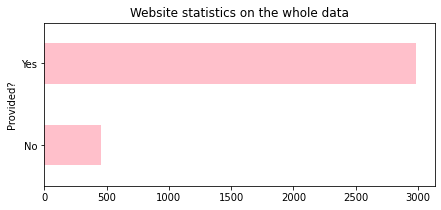

In [282]:
web_chart = merged_df['Website'].value_counts()
web_chart = web_chart.sort_values(ascending=True)
web_chart.plot(kind="barh", figsize=(7, 3), title='Website statistics on the whole data', 
                xlabel='Provided?', ylabel='Count', color='pink')

<AxesSubplot:title={'center':'Website statistics on the Pure GAP data only'}, ylabel='Provided?'>

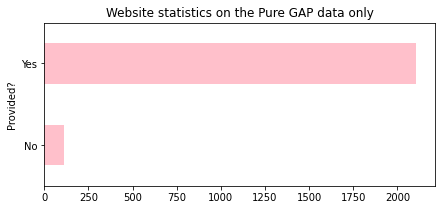

In [50]:
web_gap = gap_df['Website'].value_counts()
web_gap = web_gap.sort_values(ascending=True)
web_gap.plot(kind="barh", figsize=(7, 3), title='Website statistics on the Pure GAP data only', 
                xlabel='Provided?', ylabel='Count', color='pink')

<AxesSubplot:title={'center':'Website statistics on the Package citation data'}, ylabel='Provided?'>

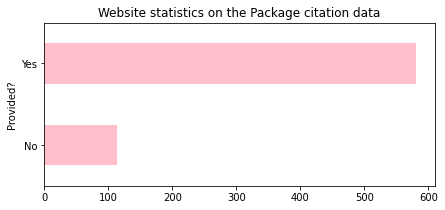

In [51]:
web_pac = pac_df['Website'].value_counts()
web_pac = web_pac.sort_values(ascending=True)
web_pac.plot(kind="barh", figsize=(7, 3), title='Website statistics on the Package citation data', 
                xlabel='Provided?', ylabel='Count', color='pink')

In [52]:
site_year = merged_df.groupby('Website').count()
site_year

,MR,Author,Journal,Year,Publication Type,Citation,Version,Lentght
Website,,,,,,,,
No,226,226,226,226,226,226,226,226
Yes,2687,2687,2687,2687,2687,2687,2687,2687


from pandas.plotting import parallel_coordinates

parallel_coordinates(all_years, "Year")

### Lenght
* Most citations are around 110 characters long.

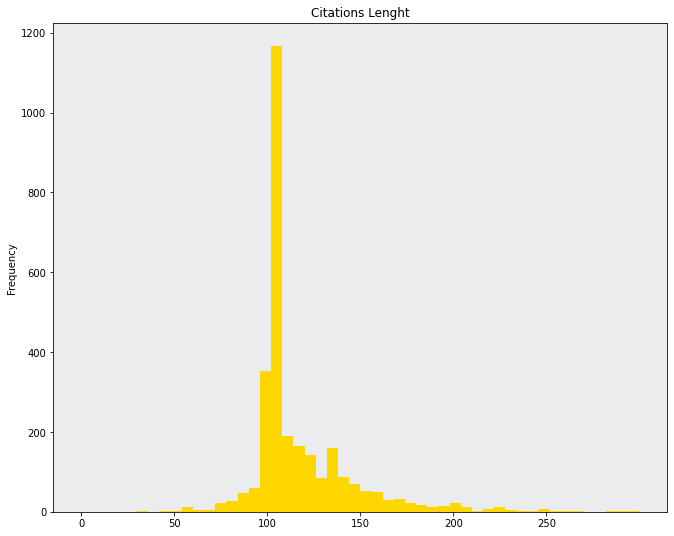

In [53]:
merged_df['Lentght'] = merged_df['Citation'].apply(len)
cit_len = merged_df['Lentght'].plot(kind='hist', bins=50, figsize=(11,9), stacked=True, 
                         xticks = range(0, 300, 50), 
                         range=(0, 300), 
                         color='gold', 
                         title='Citations Lenght', 
                         xlabel="lenght")
cit_len.set_facecolor('#ebeced')


year_df = merged_df.sort_values(by='Year', ascending=False)
year_df.dropna()
num = year_df['Journal'].count()
year_df.plot(x='Year', y=num, kind='barh')


### Version

<AxesSubplot:title={'center':'Top 50 most cited GAP versions'}, xlabel='Version', ylabel='Count'>

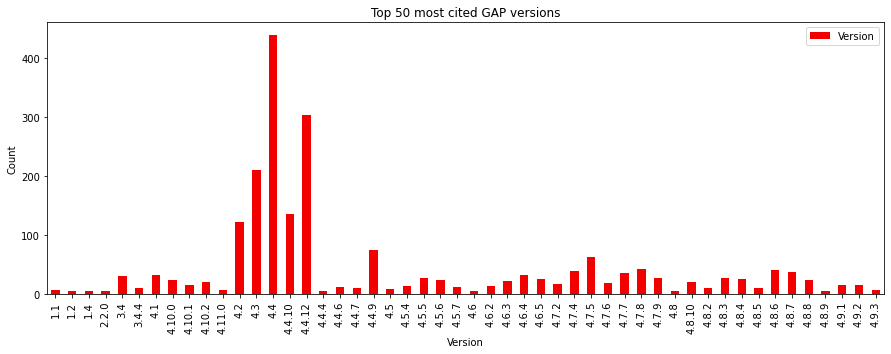

In [54]:
ver = gap_df['Version'].value_counts()
ver = ver.head(50)
ver = ver.to_frame()
ver = ver.sort_index() # sort chrono. compare version numbers
ver = ver.dropna()
ver.plot(kind="bar", figsize=(15, 5), title='Top 50 most cited GAP versions', xlabel='Version', 
                ylabel='Count', color='#f20000')

* We can see that the most popular GAP versions cited are subversions of GAP 4, between 4.2 and 4.4

In [55]:
gap_df['Version'].value_counts()

4.4         439
4.4.12      303
4.3         211
4.4.10      135
4.2         122
           ... 
3.2           1
5.7           1
2.19          1
4.5.3         1
10.01.16      1
Name: Version, Length: 97, dtype: int64

### Authors

* Top 20 authors citing GAP and its packages in their work.

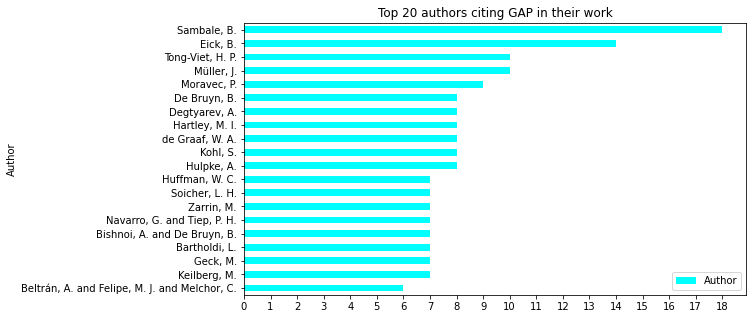

In [283]:
authors = gap_df['Author'].value_counts()
top = authors.head(20)
top = top.sort_values(ascending=True)
top = top.to_frame()
chart = top.plot(kind="barh",
                 figsize=(9,5), title='Top 20 authors citing GAP in their work', 
                 xlabel='Author', 
                 ylabel='Count', color='cyan', 
                  xticks=range(0, 19, 1))
# how do we treat joint papers ?

* Top 20 authors citing GAP Packages

In [57]:
author = pac_df['Author'].value_counts()
top20 = author.head(20)
top20 = top20.sort_values(ascending=False)
top20 = top20.to_frame()
top20

#chart = top20.plot(kind="bar",
#                 figsize=(9,5), title='Top 20 authors citing GAP Packages', 
#                 xlabel='Author', 
#                 ylabel='Count', color='brown', 
#                  xticks=range(0, 19, 1))

,Author
"Bächle, A. and Margolis, L.",10
"Koshitani, S. and Müller, J. and Noeske, F.",10
"Soicher, L. H.",8
"Eick, B.",7
"Douglas, A. and Repka, J.",6
"Kohl, S.",6
"Eick, B. and Horn, M.",6
"Fernandes, V. H.",5
"Cant, A. and Eick, B.",5
"Dabbaghian-Abdoly, V.",5


* Accuracy + site, ver, year
* Countries + to be provided
* GET function + simplicity is key

### Year

##### Barchart dislaying number of GAP citations per year.

* GAP citation counts for each year, sorted chronologically.

<AxesSubplot:title={'center':'Annual GAP citations data'}, xlabel='Year', ylabel='Count'>

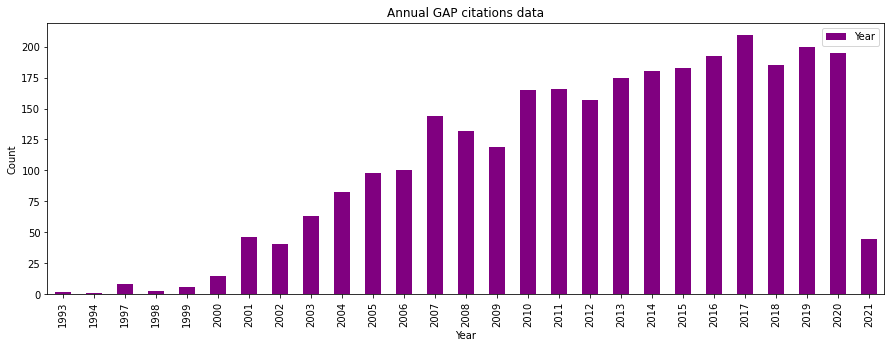

In [58]:
year_chrono = merged_df['Year'].value_counts()
chrono_df = year_chrono.to_frame()
chrono = chrono_df.sort_index()
chrono.plot(kind="bar", figsize=(15, 5), title='Annual GAP citations data', xlabel='Year', 
                ylabel='Count', color='purple')

### Top 20 journals citing GAP.

In [59]:
top_journals = gap_df['Journal'].value_counts()
top_20 = pd.DataFrame(top_journals.head(20))
top_20.reset_index()

,index,Journal
0,J. Algebra,307
1,Comm. Algebra,146
2,J. Algebra Appl.,76
3,Discrete Math.,74
4,J. Symbolic Comput.,57
5,J. Group Theory,54
6,J. Pure Appl. Algebra,51
7,Des. Codes Cryptogr.,46
8,Internat. J. Algebra Comput.,45
9,LMS J. Comput. Math.,42


Only for alternative, useful for copy/paste plain text - quick to load.
Try to allign on the left - journals.

In [60]:
headers = ['Journal name', 'GAP Citations count']
print(tabulate(top_20, headers = headers, tablefmt = 'pretty'))

+------------------------------+---------------------+
|         Journal name         | GAP Citations count |
+------------------------------+---------------------+
|          J. Algebra          |         307         |
|        Comm. Algebra         |         146         |
|       J. Algebra Appl.       |         76          |
|        Discrete Math.        |         74          |
|     J. Symbolic Comput.      |         57          |
|       J. Group Theory        |         54          |
|    J. Pure Appl. Algebra     |         51          |
|     Des. Codes Cryptogr.     |         46          |
| Internat. J. Algebra Comput. |         45          |
|     LMS J. Comput. Math.     |         42          |
|     Arch. Math. (Basel)      |         33          |
|       Israel J. Math.        |         33          |
|     European J. Combin.      |         28          |
|       J. Combin. Des.        |         28          |
|       Algebra Colloq.        |         27          |
|         

### The most frequent type of work citing GAP: we can see that GAP is predominantly cited in articles - 2976 times.

In [61]:
types_pub = pd.DataFrame(bib_df['Publication Type'].value_counts())
types_pub.columns = ['GAP Citations Count']
types_pub.index.names = ['Publication Type']
types_pub

,GAP Citations Count
Publication Type,
article,2976
incollection,204
inproceedings,54
phdthesis,47
mastersthesis,46
book,31
misc,5
techreport,2
inbook,1


### Accuracy

<AxesSubplot:title={'center':'Annual GAP citations data'}, xlabel='Year', ylabel='Count'>

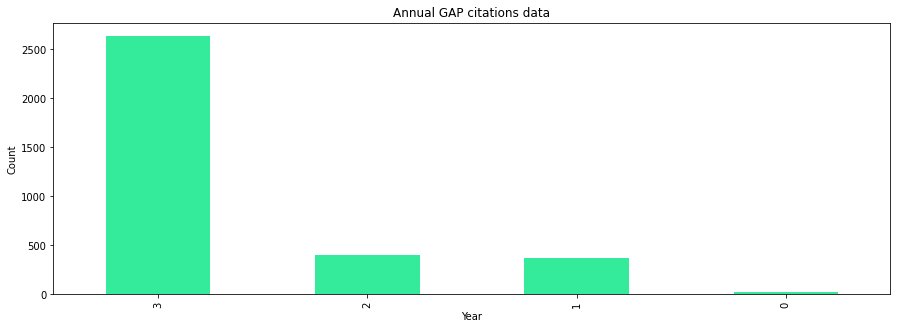

In [288]:
acc = merged_df['Accuracy Score'].value_counts()
acc.plot(kind="bar", figsize=(15, 5), title='Annual GAP citations data', xlabel='Score', 
                ylabel='Count', color='#34eb9b')

In [304]:
ttt = merged_df.groupby('Year')['Accuracy Score'].count()
ttt = pd.DataFrame(data=ttt)
ttt

,Accuracy Score
Year,
1992,1
1993,2
1994,1
1997,20
1998,16
1999,21
2000,61
2001,90
2002,67


In [301]:
df2 = gap_df.groupby(['Year', 'Accuracy Score'])
df2.head(11)

,MR,Author,Journal,Year,Publication Type,Citation,Version,Website,Lentght,Accuracy Score,Lenght
0,4056124,"Abas, M. and Vetrík, T.",Theoret. Comput. Sci.,2020,article,"GAP – Groups, algorithms, programming - a system for computational discrete algebra, www.gap-system.org.",Unknown,Yes,104,2,104
2,3942387,"Abbas, A. and Assi, A. and García-Sánchez, P. A.",Rev. R. Acad. Cienc. Exactas Fís. Nat. Ser. A Mat. RACSAM,2019,article,"The GAP Group: GAP—groups, algorithms, and programming, version 4.7.5 (2014). http://www.gap-system.org. Accessed 19 Aug 2017",4.7.5,Yes,125,3,125
3,3354065,"Abdolghafourian, A. and Iranmanesh, M. A.",Comm. Algebra,2015,article,"The GAP – Groups, Algorithms and Programming. Version 4.4.12, 2008. www.gap-system.org.",4.4.12,Yes,87,2,87
4,3646312,"Abdolghafourian, A. and Iranmanesh, M. A. and Niemeyer, A. C.",J. Pure Appl. Algebra,2017,article,"The GAP Group, GAP–Groups, Algorithms, and Programming, 4.7.8, 2015, http://www.gap-system.org.",4.7.8,Yes,95,3,95
5,1864795,"Abdollahi, A.",Houston J. Math.,2001,article,"M. Schönert et al. GAP - Groups, Algorithms, and Programming (Lehrsthul D für Mathematik, Reinisch-Westflische Technische Hochschule, Aachen, Germany, fi...",Unknown,No,168,1,168
...,...,...,...,...,...,...,...,...,...,...,...
3528,2347912,"Maksimenko, A. A. and Mamontov, A. S.",Sibirsk. Mat. Zh.,2007,article,"Kargapolov M. I. and Merzlyakov Yu. I., Fundamentals of the Theory of Groups, Springer-Verlag, New York; Heidelberg; Berlin (1979). \nMR0551207",Unknown,No,142,1,142
3529,1695079,"Mathas, A.",J. Algebraic Combin.,1999,article,"M. Schönert et al., ""Gap: groups, algorithms, and programming,"" Lehrstuhl D für Mathematik, RWTH Aachen, 3.4.4 edition, 1997.",3.4.4,No,125,2,125
3534,4187238,"Morgan, L. and Morris, J. and Verret, G.",J. Algebra,2021,article,"The Gap Group, Gap–groups, algorithms, and programming, http://www.gap-system.org, 2015.",Unknown,Yes,88,1,88
3535,1615333,"Nebe, G.",Represent. Theory,1998,article,"M. Schönert (ed.), Groups, Algorithms and Programming. Lehrstuhl D für Mathe- matik, RWTH Aachen, Germany (1994) available via anonymous ftp on the serve...",Unknown,No,193,1,193


### Releases by year

First we create a copy of our corpus dataset, containing only GAP citations with versions provided, all other entries such as Package citations are removed.

In [62]:
versions_cited = gap_df['Version'].unique()

In [63]:
versions_cited

array(['4.7.5', '4.4.12', '4.7.8', '4.3', '4.4', '4.4.4', '4.6.4',
       '4.7.2', '4.6.5', '4.7.9', '4.8.8', '4.8.9', '4.4.10', '4.5.7',
       '4.7.4', '4.7.7', '4.2', '4.6.12', '4.1', '4.10.0', '4.8.6',
       '4.8.2', '4.10.2', '4.11.0', '4.4.2', '4.8.3', '10.1109', '4.8.7',
       '4.6', '2.12', '4.9.1', '4.4.9', '4.8.4', '4.6.2', '1.2', '4.9.3',
       '4.8.10', '4.5', '4.4.6', '4.4.7', '4.5.5', '1.4', '1.3.3',
       '4.4.11', '5.7', '1.5.4', '4.10.1', '1.0.0', '4.4.10.2007',
       '4.6.3', '1405.5063', '1.1', '3.4', '4.8.5', '4.5.6', '4.11',
       '4.10', '4.9.2', '4.7.6', '4.6.9', '4.5.4', '3.4.4', '4.08.10',
       '0710.3267', '0911.5589', '4.8', '4.9.0', '4.7', '3.3', '2.19',
       '0.97', '10.14760', '1.2.1', '2.2.0', '1.5.1', '3.0', '2.0.0',
       '4.4.2006', '4.5.3', '2.1.0', '3.1.0', '3.4.3', '1.0',
       '55.0810.04', '4.6.1', '4.4.3', '4.8.1', '1.9.6', '1804.09707',
       '3.1', '4.4.5', '1.4.0', '4.46', '4.9', '4.49', '10.01.16', '3.2'],
      dtype=object)

In [64]:
release_dates = { 
    # dates from archive timestamps
    '4.8.2': 2016, # 2016/02/20
    '4.7.9': 2015, # 2015/11/29
    '4.7.8': 2015, # 2015/06/09
    '4.7.7': 2015, # 2015/02/13
    '4.7.6': 2014, # 2014/11/15
    '4.7.5': 2014, # 2014/05/24
    '4.7.4': 2014, # 2014/02/20
    '4.7.3': 2013, # 2014/02/15
    '4.7.2': 2013, # 2013/12/01
    '4.7': 2013,
    '4.6.5': 2013, # 2013/07/20
    '4.6.4': 2013, # 2013/05/04
    '4.6.3': 2013, # 2013/03/18
    '4.6.2': 2013, # 2013/02/02
    '4.5.7': 2012, # 2012/12/14
    '4.5.6': 2012, # 2012/09/16
    '4.5.5': 2012, # 2012/07/16
    '4.5.4': 2012, # 2013/06/04
    '4.5': 2012, 
    # dates below from file creation
    '4.4.12': 2008, # 2008/12/16
    '4.4.11': 2008, # 2008/12/08
    '4.4.10': 2007, # 2007/10/05
    '4.4.9': 2006,  # 2006/11/02
    '4.4.8': 2006,  # 2006/09/29
    '4.4.7': 2006,  # 2006/03/17
    '4.4.6': 2005,  # 2005/09/02
    '4.4.5': 2005,  # 2005/05/13
    '4.4.4': 2004,  # 2004/12/22
    # dates below from http://www.gap-system.org/Download/Updates/index.html
    '4.4.3': 2004,   # May 2004
    '4.4.2': 2004,  # April 2004
    # dates from http://www.gap-system.org/Doc/History/history.html
    # if not stated otherwise
    '4.4': 2004, 
    '4.3': 2002, 
    '4.2': 2000, # http://www.gap-system.org/ForumArchive/Linton.1/Steve.1/Release_.3/1.html
    '4.1': 1999, 
    '3.4': 1997, # assume http://www.gap-system.org/Doc/History/preface_3.4.4.html
}

In [65]:
release_dates.keys()

dict_keys(['4.8.2', '4.7.9', '4.7.8', '4.7.7', '4.7.6', '4.7.5', '4.7.4', '4.7.3', '4.7.2', '4.7', '4.6.5', '4.6.4', '4.6.3', '4.6.2', '4.5.7', '4.5.6', '4.5.5', '4.5.4', '4.5', '4.4.12', '4.4.11', '4.4.10', '4.4.9', '4.4.8', '4.4.7', '4.4.6', '4.4.5', '4.4.4', '4.4.3', '4.4.2', '4.4', '4.3', '4.2', '4.1', '3.4'])

In [66]:
def release_year(version):
    if version in release_dates.keys():
        return release_dates[version]
    else:
        return 'Unknown'

In [67]:
release_year('4.7.2')

2013

In [68]:
gap_df['ReleaseYear'] = gap_df['Version'].map(release_year)

In [69]:
data = gap_df['ReleaseYear'].value_counts()

* Number of Citations by year of cited GAP release, in textual and graphic forms.

In [70]:
data

2004       449
Unknown    403
2008       307
2002       211
2007       135
2000       122
2014       120
2013       112
2015       105
2006        86
2012        84
1999        32
1997        30
2005        13
2016        10
Name: ReleaseYear, dtype: int64

<AxesSubplot:title={'center':'Citations by year of cited GAP release'}, xlabel='Years', ylabel='Count'>

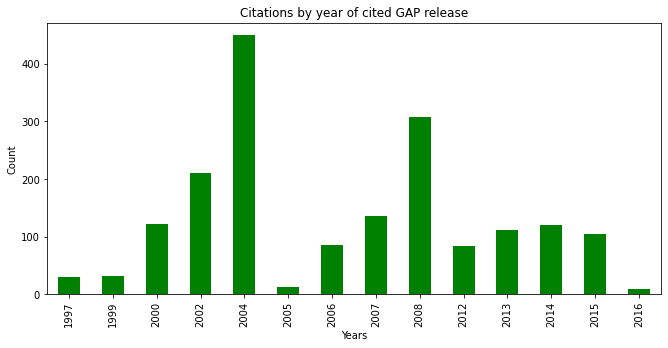

In [305]:
data.loc[sorted(data.index.intersection(range(1997, 2021)))].plot(kind="bar", 
                figsize=(11, 5), title='Citations by year of cited GAP release', xlabel='Years', 
                ylabel='Count', color='green')

<AxesSubplot:title={'center':'pie'}, ylabel='Frequency'>

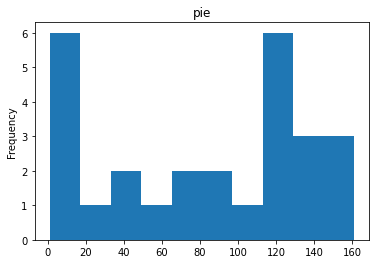

In [127]:
dat.plot(kind="hist", title="pie")

all_years = corpus_df.groupby(['year','ReleaseYear'])['Year'].count()
all_years

In [148]:
get_c('2592492')

,MR,Author,Journal,Year,Publication Type,Citation,Version,Website,Lentght
3532,2592492,"McInroy, J. and Shpectorov, S.",Discrete Math.,2010,article,"The Gap Group, Gap - Groups, Algorithms, and Programming, Version 4.4.10, 2007. http://www.gap-system.org.",4.4.10,Yes,106
3533,2592492,"McInroy, J. and Shpectorov, S.",Discrete Math.,2010,article,"L.H. Soicher, The Grape package for Gap, Version 4.3, 2006. http://www.maths.qmul.ac.uk/simleonard/grape/.",Package,Yes,106


In [146]:
years = gap_df['Year'].unique()
dat = gap_df['Year'].value_counts()
g = gap_df['Version'].value_counts()
ver = gap_df['Version'].unique()

In [155]:
gap_df['Publication Type'].value_counts()

article          2196
incollection       20
inproceedings       3
Name: Publication Type, dtype: int64

In [165]:
yea = gap_df.groupby(['Publication Type', 'Year'])['Publication Type'].count()
yea = pd.DataFrame(data=yea)
yea

Publication Type
Publication Type Year                  
article          1993                 2
                 1994                 1
                 1997                 8
                 1998                 3
                 1999                 4
                 2000                 7
                 2001                26
                 2002                24
                 2003                48
                 2004                68
                 2005                83
                 2006                80
                 2007               116
                 2008               108
                 2009                93
                 2010               130
                 2011               121
                 2012               124
                 2013               128
                 2014               126
                 2015               132
                 2016               126
                 2017               161
                 2018               142
                 2019               146
                 2020               154
                 2021                35
incollection     2000                 3
                 2001                 6
                 2002                 5
                 2003                 5
                 2004                 1
inproceedings    2001                 1
                 2003                 2

<AxesSubplot:title={'center':'Citations by year of cited GAP release'}, xlabel='Years', ylabel='Count'>

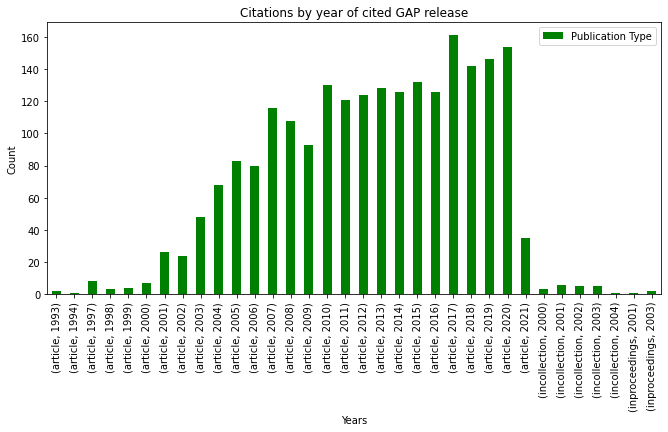

In [166]:
yea.plot(kind="bar", 
                figsize=(11, 5), title='Citations by year of cited GAP release', xlabel='Years', 
                ylabel='Count', color='green')

In [170]:
jou = gap_df.groupby('Year')['Journal'].unique()
jou = pd.DataFrame(data=jou)
jou

,Journal
Year,
1993,[Math. Comp.]
1994,[Math. Comp.]
1997,"[Trans. Amer. Math. Soc., J. Algebra, J. London Math. Soc. (2), Comment. Math. Helv., Proc. Amer. Math. Soc., Proc. London Math. Soc. (3)]"
1998,"[J. Math. Soc. Japan, Math. Comp., J. London Math. Soc. (2)]"
1999,"[J. Algebra, Bull. London Math. Soc., Proc. London Math. Soc. (3), J. Algebraic Combin.]"
2000,"[Discrete Math., J. Algebra, J. Symbolic Comput., Comm. Algebra]"
2001,"[Quaest. Math., Comm. Algebra, J. Algebra, Boll. Unione Mat. Ital. Sez. B Artic. Ric. Mat. (8), Discrete Math. Theor. Comput. Sci., J. Korean Math. Soc.,..."
2002,"[Acta Sci. Math. (Szeged), Comm. Algebra, Internat. J. Algebra Comput., J. Combin. Des., J. Algebra, Des. Codes Cryptogr., Theoret. Comput. Sci., J. Symb..."
2003,"[Discrete Math., Represent. Theory, LMS J. Comput. Math., J. Combin. Theory Ser. A, European J. Combin., J. Symbolic Comput., Comm. Algebra, Finite Field..."


In [92]:
lee = gap_df.groupby('Lentght')
lee.size()

Lentght
54      1
55      1
56      2
58      2
61      1
       ..
265     1
283     1
287     1
288     1
1076    1
Length: 127, dtype: int64

In [142]:
au7 = gap_df['Author'].unique()
au7

array(['Abbas, A. and Assi, A. and García-Sánchez, P. A.',
       'Abdolghafourian, A. and Iranmanesh, M. A.',
       'Abdolghafourian, A. and Iranmanesh, M. A. and Niemeyer, A. C.',
       ..., 'Künzer, M. and Mathas, A.', 'Mathas, A.',
       'McInroy, J. and Shpectorov, S.'], dtype=object)

In [131]:
df2 = gap_df.groupby(['Year', 'ReleaseYear'])['ReleaseYear'].count().unstack('Year').fillna(0)
df2.head(11)

Year,1993,1994,1997,1998,1999,2000,2001,2002,2003,2004,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
ReleaseYear,,,,,,,,,,,,,,,,,,,,,
1997,0.0,0.0,5.0,1.0,2.0,7.0,5.0,3.0,5.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1999,0.0,0.0,0.0,0.0,0.0,2.0,10.0,6.0,4.0,4.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000,0.0,0.0,0.0,0.0,0.0,0.0,15.0,17.0,27.0,21.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,37.0,...,7.0,1.0,7.0,2.0,3.0,1.0,0.0,2.0,3.0,0.0
2004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,30.0,19.0,22.0,15.0,19.0,12.0,14.0,10.0,15.0,0.0
2005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.0,6.0,3.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0
2007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,14.0,10.0,6.0,8.0,6.0,6.0,3.0,2.0,1.0,0.0
2008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,58.0,61.0,32.0,26.0,13.0,15.0,10.0,6.0,3.0,0.0


c:\users\fliqp_000\appdata\local\programs\python\python38-32\lib\site-packages\numpy\ma\core.py:2825: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _data = np.array(data, dtype=dtype, copy=copy,


ValueError: x and y must be the same size

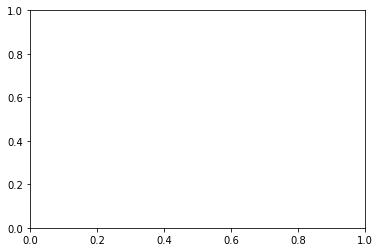

In [143]:
#objects = gap_df['Year']

plt.scatter(lee, years, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Usage')
plt.title('Programming language usage')

plt.show()

# Interactive

In [139]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cufflinks as cf

In [ ]:
def y_selector(x):
    return gap_df[gap_df['Year'] == x]

In [ ]:
def h(p, q):
    return (p, q)

In [ ]:
gap_df['Year'].value_counts()

In [ ]:
dat = gap_df['Year'].value_counts()
years = dat.index
years = years.sort_values()
years

In [ ]:
yea = interact(y_selector, x=years);

Versions / year
top authors / year
data per year

In [ ]:
def get_info(db, food, nutrient):
    food_info = db
    for word in food.split():
        food_info = food_info[food_info['Food'].str.contains(word, case=False)]
    nutritional_info = food_info[food_info['Nutrient'] == nutrient]
    return nutritional_info

interact(lambda food, nutrient: get_info(db, food, nutrient),
        food='',
        nutrient=list(db['Nutrient'].unique()))

In [140]:
def get_info(db, author, citation):
    auth_info = db
    for word in author.split():
        auth_info = auth_info[auth_info['Author'].str.contains(word, case=False)]
    cit_info = auth_info[auth_info['Citation'] == citation]
    return cit_info

interact(lambda author, citation: get_info(gap_df, author, citation),
        author = '',
        citation = list(gap_df['Citation'].unique()))

interactive(children=(Text(value='', description='author'), Dropdown(description='citation', options=('The GAP…

<function __main__.<lambda>(author, citation)>

In [141]:
yea = widgets.FloatSlider(min=min(gap_df['Year']), max=max(gap_df['Year']), step=1, description='Year')
display(yea)

FloatSlider(value=1993.0, description='Year', max=2021.0, min=1993.0, step=1.0)

In [ ]:
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np


%matplotlib nbagg

x = np.linspace(0, 2, 1000)
fig, ax = plt.subplots(1, figsize=(10, 4))
plt.suptitle('Sine Wave')


def update_plot(amp, phase, freq):
    
    ax.clear()
    y = amp * np.sin(freq * 2 * np.pi * x + phase * 2 * np.pi)
    units = 'amp = {} $(psi)$ \nphase = {} $(s)$ \nfreq = {} $(Hz)$'
    
    ax.plot(x, y, label=units.format(amp, phase, freq))
    ax.set_xlim(x[0], x[-1])
    ax.legend(loc=1)
    ax.set_xlabel('$(s)$')
    plt.show()


amp = widgets.FloatSlider(min=1, max=10, value=1, description='Amp:')
phase = widgets.FloatSlider(min=0, max=5, value=0, description='Phase:')
freq = widgets.FloatSlider(min=1, max=10, value=1, description='Freq:')
    
widgets.interactive(update_plot, amp=amp, phase=phase, freq=freq)